### PPAML Challenge Problem 7

University of California, Berkeley

Submission for BLOG by Prof. Stuart Russell's group.

#### Flu spread model

To quickly recap: we observe region-level statistics and want to query for county-level statistic.

We will consider an *undirected model* with pairwise potentials (this is equivalent to a MV Gaussian). The potentials connect neighboring counties in space and identical counties across time (as dictated by hyperparameter $\rho$).

The primary model is built into `flu_spread_model.blog`; the primary purpose of this notebook is to perform pre-processing to get our data into BLOG correctly. We will write the following additional files:

- `flu_spread_region_rate.blog`
- `flu_spread_obs.blog`
- `flu_spread_queries.blog`

<img style="display:inline;" src="images/gmrf.png" /><img style="display:inline;"  src="images/adjacency.png" />
<img style="display:inline;" src="images/model.png" />

In [1]:
import functools
import json
import numpy as np
import pandas as pd
import pickle
import re
import sys

from collections import defaultdict
from datetime import datetime

In [2]:
def is_kernel():
    if 'IPython' not in sys.modules:
        return False
    from IPython import get_ipython
    return getattr(get_ipython(), 'kernel', None) is not None

In [3]:
if not is_kernel():
    if len(sys.argv) <= 1:
        print("Need to specify training size.")
        sys.exit()
    TRAINING_SIZE = sys.argv[1]
else:
    TRAINING_SIZE = 'Small'

#### Load the data.

Need to make sure to load from the right training data size.

In [4]:
ili_data            = pd.read_csv("data/%s/input/Flu_ILI.csv" % TRAINING_SIZE)
tweets_data         = json.load(open("data/%s/input/Flu_Vacc_Tweet_TRAIN.json" % TRAINING_SIZE))
states              = json.load(open("data/%s/input/StateInfo.json" % TRAINING_SIZE))
regions_to_counties = json.load(open("data/%s/input/Region2CountyMap.json" % TRAINING_SIZE))
county_adjacency    = json.load(open("data/%s/input/county_adjacency_lower48.json" % TRAINING_SIZE))

#### List the dates.

It's important that the dates are in chronological order.<br/>
The index of the event is important for writing observations.

In [5]:
dates = list(map(lambda s: datetime.strptime(s, "%m/%d/%Y").date().strftime('%m/%d/%Y'), ili_data["Ending"]))

In [6]:
print("Number of dates:", len(dates))

Number of dates: 103


#### Compute county statistics.

We need to compute *covariates* and *population* for each county.

$$\begin{align}
    N_c & = \texttt{ loaded from data }\\
    X_{c,t} & = \begin{bmatrix} 
                    \log{(\frac{S_{c,t} + \epsilon_2}{\tilde{N}_c})} & 
                    \log{(\frac{V_{c,t} + \epsilon_3}{1-V_{c,t}+\epsilon_3})} 
                \end{bmatrix}^T\\
\end{align}$$

Where 
$$\begin{align}
    \epsilon_2 & = 0.1\\
    \epsilon_3 & = 0.001\\
\end{align}$$

The covariate matrices should be of size $n$ by $d$.<br />
The population vector should be of size $n$ by $1$.

In [7]:
fips_to_cov1 = defaultdict(list)
fips_to_cov2 = defaultdict(list)
fips_to_pop = {}

In [8]:
for fips_code, blob in tweets_data.items():
    
    if not 'Vaccination percentage %' in blob.keys():
        continue
    
    vacc_percentage = 0.0
        
    for date in dates:
    
        if date not in blob['No. of Tweets']:
            cov1 = np.log(0.1 / blob['Population, 2014 estimate'])
            cov2 = np.log(0.001 / (1 + 0.001))
        else:
            cov1 = np.log((blob['No. of Tweets'][date] + 0.1) / blob['Population, 2014 estimate'])
            cov2 = np.log(((blob['Vaccination percentage %'][date] / 100 - vacc_percentage)  + 0.001) / 
                           (1-(blob['Vaccination percentage %'][date] / 100 - vacc_percentage) + 0.001))

#             vacc_percentage = blob['Vaccination percentage %'][date] / 100
            
        fips_to_cov1[fips_code].append(cov1)
        fips_to_cov2[fips_code].append(cov2)
        
    fips_to_pop[fips_code] = blob['Population, 2014 estimate']

#### Construct sets of regions and counties.

We extract regions and counties for *only* the relevant counties from the training data.<br />

In [9]:
regions = set()
for i, col in enumerate(ili_data.columns):
    if i > 3:
        regions.add(col)

In [10]:
counties = set()
for r in regions:
    counties = counties.union(set(regions_to_counties[r].keys()))

In [11]:
print('Number of regions:', len(regions))
print('Number of counties:', len(counties))

Number of regions: 9
Number of counties: 82


#### Save county data.

Note: we assign an index to each county (somewhat arbitrarily).

We also create (and make sure to use) the following dictionaries:
- index_to_county
- county_to_index

#### Map regions to counties.

We construct a resulting matrix $A$ that contains
$$A_{i,j} = \begin{cases} N_j & \mbox{if region } i \mbox{ contains county } j\\
                          0 & \mbox{otherwise}  \end{cases}$$
                                               
Also calculate the region population by
$$N_r = \sum_{c \in r} N_c$$

The resulting matrix should be of size $m$ by $n$.

In [31]:
county_to_index = {}
for i, fips in enumerate(counties):
    county_to_index[fips] = i
index_to_county = {v: k for k, v in county_to_index.items()}

In [32]:
region_to_index = {}
for i, r in enumerate(regions):
    region_to_index[r] = i
index_to_region = {v: k for k, v in region_to_index.items()}

In [33]:
county_pop_matrix = []
cov1_matrix = []
cov2_matrix = []

for i, fips in index_to_county.items():
    county_pop_matrix.append(fips_to_pop[fips])
    cov1_matrix.append(fips_to_cov1[fips])
    cov2_matrix.append(fips_to_cov2[fips])

county_pop_matrix = np.array(county_pop_matrix)
cov1_matrix = np.array(cov1_matrix)
cov2_matrix = np.array(cov2_matrix)

In [34]:
county_map_matrix = np.zeros((len(regions), len(counties)))
region_pop_matrix = [0] * len(regions)

for i, r in index_to_region.items():
    
    for fips in regions_to_counties[r]:
        if fips not in county_to_index:
            continue
        county_map_matrix[i][county_to_index[fips]] = county_pop_matrix[county_to_index[fips]]
        region_pop_matrix[i] += fips_to_pop[fips]

In [35]:
np.savetxt('data_processed/county_map.txt', county_map_matrix)
np.savetxt('data_processed/region_pops.txt', region_pop_matrix)

In [36]:
print(county_map_matrix.shape)

(9, 82)


In [37]:
cov1_matrix = np.dot(county_map_matrix, cov1_matrix) / np.array(region_pop_matrix)[:, np.newaxis]

In [38]:
cov1_matrix = np.dot((county_map_matrix > 0).astype(int).T, cov1_matrix)

In [39]:
cov1_ewma = np.zeros_like(cov1_matrix)
cov2_ewma = np.zeros_like(cov2_matrix)

In [40]:
ewma_window = 10

In [41]:
for i in range(len(cov1_matrix)):
  cov1_ewma[i] = pd.ewma(cov1_matrix[i], span=ewma_window)

In [42]:
for i in range(len(cov2_matrix)):
  cov2_ewma[i] = pd.ewma(cov2_matrix[i], span=ewma_window)

In [43]:
for i in range(len(cov1_matrix)):
  cov1_matrix[i] = 2 * cov1_ewma[i] - pd.ewma(cov1_ewma[i], span=ewma_window)
for i in range(len(cov2_matrix)):
  cov2_matrix[i] = 2 * cov2_ewma[i] - pd.ewma(cov2_ewma[i], span=ewma_window)

In [44]:
cov1_matrix.shape

(82, 103)

In [50]:
cov1_matrix = (cov1_matrix - np.mean(cov1_matrix)) / np.std(cov1_matrix)
cov2_matrix = (cov2_matrix - np.mean(cov2_matrix)) / np.std(cov2_matrix)

In [51]:
np.savetxt('data_processed/covariates1.txt', cov1_matrix)
np.savetxt('data_processed/covariates2.txt', cov2_matrix)

In [52]:
import matplotlib.pyplot as plt
% matplotlib inline

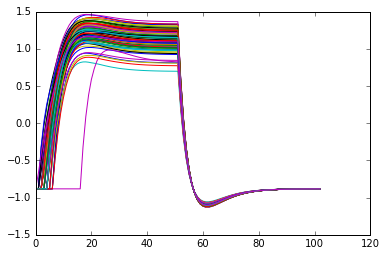

In [53]:
plt.plot(cov2_matrix.T)

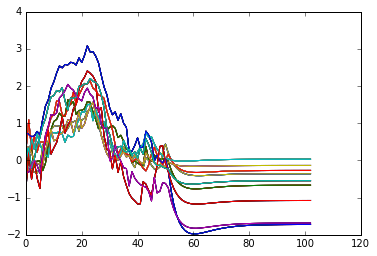

In [54]:
plt.plot(cov1_matrix.T)

In [35]:
print(cov1_matrix.shape)
print(cov2_matrix.shape)
print(county_pop_matrix.shape)

(82, 103)
(82, 103)
(82,)


#### Construct correlation matrices.

Assuming the undirected model, we have a single covariance matrix of size $n$ by $n$ (where $n$ is the number of counties). Construct following precision matrix with hyperparameter $\tau_1 \sim \mbox{Gamma}(3, 0.1)$.
$$\Sigma^{-1} = \tau_1 (D_w - W)$$

Therefore the output from this step is a matrix
$$\Sigma^{-1} = (D_w - W) + 0.01 I$$

Where $W$ is a symmetric matrix:
$$W_{i,j} = \begin{cases} 1 & \mbox{if } i \mbox{ neighbors } j\\ 0 & \mbox{otherwise} \end{cases}$$
And $D_w$ is a diagonal matrix:
$$Dw_{i,i} = \sum_j W_{i,j}$$
And $I$ is meant for regularization to ensure the matrix is positive definite.

In [36]:
W = np.zeros(((len(counties), len(counties))))

for blob in county_adjacency.values():
    
    fips = blob[1]
    neighbors = blob[2].values()
    
    if fips not in county_to_index:
        continue
        
    i = county_to_index[fips]
    for n in neighbors:
        if not n in county_to_index:
            continue
        j = county_to_index[n]
        if i == j:
            continue
        W[i][j] = 1
        W[j][i] = 1

In [37]:
np.savetxt("data_processed/W.txt", W)

In [38]:
D = np.zeros(((len(counties), len(counties))))

for i in range(len(counties)):
    D[i,i] = np.sum(W[i,:])

In [39]:
#D = D / np.max(D)

In [40]:
print(D)

[[ 9.  0.  0. ...,  0.  0.  0.]
 [ 0.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  6. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  4.  0.  0.]
 [ 0.  0.  0. ...,  0.  6.  0.]
 [ 0.  0.  0. ...,  0.  0.  6.]]


In [41]:
np.savetxt('data_processed/D.txt', np.diag(D))

**Manage spatial triples.**

In [42]:
spatial_triples = []
for i in range(W.shape[0]):
  for j in range(W.shape[1]):
    if W[i][j] == 1:
#       for t in range(len(dates)):
      spatial_triples.append((i,j))

In [43]:
print("Spatial pairs:", len(spatial_triples))

Spatial pairs: 432


In [44]:
np.savetxt("data_processed/spatial_obs.txt", np.array(spatial_triples))

**Manage temporal triples.**

In [45]:
temporal_triples = []
for t in range(len(dates) - 1):
#   for c in range(len(counties)):
  temporal_triples.append((t, t+1))

In [46]:
print("Temporal pairs:", len(temporal_triples))

Temporal pairs: 102


In [47]:
np.savetxt("data_processed/temporal_obs.txt", np.array(temporal_triples))

#### Write headers for BLOG code

In [48]:
header_file = open("flu_spread_header.blog", "w")
header_file.write("""
type County;
type Region;
type Week;
type SpatialPair;
type TemporalPair;

distinct County counties[{0}];
distinct Region regions[{1}];
distinct Week weeks[{2}];
distinct SpatialPair spatial_pairs[{3}];
distinct TemporalPair temporal_pairs[{4}];

""".format(len(counties), len(regions), len(dates), len(spatial_triples), len(temporal_triples)))
header_file.close()

#### Write observations.

We ignore any entries that are NaN in the training data.

In [54]:
obs = np.ones((len(dates), len(regions))) * -1

In [55]:
for i, row in ili_data.iterrows():
    
    for j, region in index_to_region.items():

        if pd.isnull(row[region]):
            continue
            
        rate = float(row[region].strip('%')) / 100
        obs[i][j] = rate

In [57]:
np.savetxt("data_processed/obs.txt", obs)

**Write priors.**

In [66]:
priors = np.zeros((len(counties), len(dates)))

In [63]:
priors.shape

(82, 103)

In [70]:
for c in range(len(counties)):
  for t in range(len(dates)):
    priors[c][t] = obs[t][np.argmax(county_map_matrix[:,c])] + 0.001

In [71]:
priors = -1 * np.log((1 - priors) / (priors))

In [72]:
np.savetxt("data_processed/priors.txt", priors)

#### Write region-level rates BLOG code, observations, and queries.

In [73]:
footer_file = open("flu_spread_footer.blog", "w")
region_variance = 0.005

In [74]:
footer_file.write("""
random Real region_rate(Region r, Week t) ~ 
  Gaussian(
    accu(county_map[toInt(r)] * vstack(
""")
for i in range(len(counties) - 1):
    footer_file.write("      sigmoid(logit(counties[%d], t)),\n" % i)
footer_file.write("      sigmoid(logit(counties[%d], t)))) / region_pop[toInt(r)],\n" % (len(counties) - 1))
footer_file.write("    %f);\n\n" % region_variance)
footer_file.write("""

obs region_rate(r, t) = observations[toInt(t)][toInt(r)] for Region r, Week t: observations[toInt(t)][toInt(r)] > -1.0;

query tau1;
query rho;
query beta1;
query beta2;

query logit(c, t) for County c, Week t;
""")
footer_file.close()

#### Save necessary data for post-processing.

In [75]:
with open("log/dates.pickle", "wb") as outfile:
    pickle.dump(dates, outfile)

In [76]:
with open("log/index_to_county.pickle", "wb") as outfile:
    pickle.dump(index_to_county, outfile)

In [77]:
with open("log/index_to_region.pickle", "wb") as outfile:
    pickle.dump(index_to_region, outfile)